# Reproducing Chlorophyll-a Analysis in Santa Monica Bay Using Landsat 8
This notebook aims to reproduce and extend the analysis conducted in the ocean remote sensing project titled "Remote Sensing of Chlorophyll-a using Landsat 8". The original project, available  [here](https://romero61.github.io/posts/SMB/), focused on the analysis of Chlorophyll-a concentrations in the Santa Monica Bay. The study was based on the methodology proposed by Trinh et al. 2017.

We utilize Landsat 8 satellite imagery to estimate Chlorophyll-a concentrations, and analyze changes over time, particularly focusing on the impact of the Hyperion Treatment Plant failure.

The notebook includes the following steps:

1. Importing necessary Python libraries for data manipulation, mathematical operations, data visualization, handling date and time data, interacting with Google Earth Engine, and handling geospatial data.

2. Initializing the Earth Engine API and creating an interactive map using the geemap library.

3. Defining the collection of satellite images to be used (Landsat 8 OLI images) and the study area.

4. Processing the satellite images, including applying scale factors and estimating Chlorophyll-a concentrations.

5. Visualizing the processed images on an interactive map.

The next steps of this project will include retrieving the most recent image from the collection, calculating basic statistics for Chlorophyll-a concentrations, allowing user-defined regions for analysis, and integrating this script into an R Shiny dashboard for interactive data exploration.

Trinh, R. C., Fichot, C. G., Gierach, M. M., Holt, B., Malakar, N. K., Hulley, G., & Smith, J. (2017). Application of Landsat 8 for Monitoring Impacts of Wastewater Discharge on Coastal Water Quality. Frontiers in Marine Science, 4. https://doi.org/10.3389/fmars.2017.00329

In [1]:
#1) Import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import ee
import geemap.foliumap as geemap
import geopandas as gpd
from datetime import datetime
import ipywidgets as widgets
import seaborn as sns


In [2]:
from constants import   STUDY_BOUNDARY_PATH


In [3]:
shapefile_path = STUDY_BOUNDARY_PATH
study_boundary = gpd.read_file(shapefile_path)

# Import Landsat8 OLI

https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2#terms-of-use

 Landsat-8 image courtesy of the U.S. Geological Survey

In [4]:
# Initialize the Earth Engine library
#ee.Authenticate()
ee.Initialize()

In [5]:
# Define the collection
collection = "LANDSAT/LC08/C02/T1_L2"

In [6]:
# Load the study area
ee_boundary = geemap.geopandas_to_ee(study_boundary)


In [7]:
aoi = ee_boundary.geometry()

In [8]:
# Define the Image Collection
image_collection = ee.ImageCollection(collection) \
    .filterBounds(aoi) \
    .sort('system:time_start', False)

In [9]:
# Get the four most recent images
recent_images = image_collection.limit(100)

In [10]:
# Get the dates of the images
dates = recent_images.aggregate_array('system:time_start').getInfo()
# Convert the timestamps to readable dates
dates = [datetime.fromtimestamp(date/1000).strftime('%Y-%m-%d') for date in dates]
# Sort the list of unique dates in descending order
dates = sorted(list(set(dates)), reverse=True)

# Print the unique dates


# Print the unique dates
print("Dates of the four most recent images:", dates)

Dates of the four most recent images: ['2023-06-10', '2023-05-25', '2023-05-09', '2023-04-07', '2023-03-22', '2023-03-06', '2023-02-18', '2023-02-02', '2023-01-17', '2023-01-01', '2022-12-16', '2022-11-30', '2022-11-14', '2022-10-29', '2022-10-13', '2022-09-27', '2022-08-26', '2022-08-10', '2022-07-25', '2022-07-09', '2022-06-23', '2022-06-07', '2022-05-22', '2022-05-06', '2022-04-20', '2022-04-04', '2022-03-19', '2022-03-03', '2022-02-15', '2022-01-30', '2022-01-14', '2021-12-29', '2021-12-13', '2021-11-27', '2021-11-11', '2021-10-26', '2021-10-10', '2021-09-24', '2021-09-08', '2021-08-23', '2021-08-07', '2021-07-22', '2021-07-06', '2021-06-20', '2021-06-04', '2021-05-19', '2021-05-03', '2021-04-17', '2021-04-01', '2021-03-16', '2021-02-28', '2021-02-12']


In [11]:
# Define a function to calculate statistics
def calculate_stats(image, region):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean().combine(
            reducer2=ee.Reducer.stdDev(),
            sharedInputs=True
        ),
        geometry=region,
        scale=30,  # scale in meters
        maxPixels=1e9
    )
    return stats.getInfo()



In [12]:
# Define a function to apply scaling and offset
def apply_scale_factors(image):
    optical_bands = image.select('SR_B.*').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    image = image.addBands(optical_bands, None, True)
    image = image.addBands(thermal_bands, None, True)
    return image


https://calekochenour.github.io/remote-sensing-textbook/03-beginner/chapter13-data-quality-bitmasks.html


In [13]:
# Define function to return QA bands

def extract_qa_bits(qa_band, start_bit, end_bit, band_name):
    """
    Extracts QA values from an image
    :param qa_band: Single-band image of the QA layer
    :type qa_band: ee.Image
    :param start_bit: Starting bit
    :type start_bit: Integer
    :param end_bit: Ending bit
    :type end_bit: Integer
    :param band_name: New name for the band
    :type band_name: String
    :return: Image with extracted QA values
    :rtype: ee.Image
    """
    # Initialize QA bit string/pattern to check QA band against
    qa_bits = 0
    # Add each specified QA bit flag value/string/pattern to the QA bits to check/extract
    for bit in range(start_bit, end_bit + 1):
        qa_bits += pow(2, bit)  # Same as qa_bits += (1 << bit)
    # Return a single band image of the extracted QA bit values
    return qa_band.select([0], [band_name]).bitwiseAnd(qa_bits).rightShift(start_bit)


In [14]:
# Define a function to calculate Chlorphyll-a based on trinh et al.(2017)
def trinh_et_al_chl_a(image):
    # extract the cloud and water masks
    qa_band = ee.Image(image).select('QA_PIXEL')
    cloudMask = extract_qa_bits(qa_band, 8, 9, "cloud").neq(3)  # different than 3 to remove clouds
    waterMask = extract_qa_bits(qa_band, 7, 7, "water").eq(1)  # equals 1 to keep water

    # apply the masks to the image
    image = image.updateMask(cloudMask).updateMask(waterMask)
    image =  apply_scale_factors(image)

    a_0 = 0.9375
    a_1 = -1.8862
    blue_bands = image.select('SR_B2')
    green_bands = image.select('SR_B3')
    ln_chl_a = image.expression("a_0 + a_1 * log(blue_bands/green_bands)", {
        'a_0': a_0,
        'a_1': a_1,
        'blue_bands': blue_bands,
        'green_bands': green_bands
    })
    image = image.addBands(ln_chl_a.select([0], ['ln_chl_a']))


    return image



In [15]:
'''# Define the function to extract the data (mean value) and area.
def extract_data(image):
    stats = image.reduceRegion(ee.Reducer.mean(), aoi, 30)
    area = image.geometry().area()
    return image.set('date', image.date().format()).set(stats).set('Area', area)'''


In [ ]:
'''# Define the function to extract the data (mean value) and area.
def extract_data(image):
    stats = image.reduceRegion(ee.Reducer.mean(), aoi, 30)
    area = image.select(0).gt(0).reduceRegion(ee.Reducer.sum(), aoi, 30).get('ln_chl_a')
    return image.set('date', image.date().format()).set(stats).set('Area', area)'''

In [20]:
# Define the function to extract the data (mean value) and valid pixel area.
def extract_data(image):
    stats = image.reduceRegion(ee.Reducer.mean(), aoi, 30)
    valid_pixels = image.select('ln_chl_a').unmask().neq(0)  # create a mask of valid pixels
    valid_area = valid_pixels.multiply(ee.Image.pixelArea()).reduceRegion(ee.Reducer.sum(), aoi, 30)  # calculate the area of valid pixels
    return image.set('date', image.date().format()).set(stats).set('Area', valid_area)

In [16]:
turbo_palette = [
    "30123b", "321543", "33184a", "341b51", "351e58", "36215f", "372466", "38276d", 
    "392a73", "3a2d79", "3b2f80", "3c3286", "3d358b", "3e3891", "3f3b97", "3f3e9c", 
    "4040a2", "4143a7", "4146ac", "4249b1", "424bb5", "434eba", "4451bf", "4454c3", 
    "4456c7", "4559cb", "455ccf", "455ed3", "4661d6", "4664da", "4666dd", "4669e0", 
    "466be3", "476ee6", "4771e9", "4773eb", "4776ee", "4778f0", "477bf2", "467df4", 
    "4680f6", "4682f8", "4685fa", "4687fb", "458afc", "458cfd", "448ffe", "4391fe", 
    "4294ff", "4196ff", "4099ff", "3e9bfe", "3d9efe", "3ba0fd", "3aa3fc", "38a5fb", 
    "37a8fa", "35abf8", "33adf7", "31aff5", "2fb2f4", "2eb4f2", "2cb7f0", "2ab9ee", 
    "28bceb", "27bee9", "25c0e7", "23c3e4", "22c5e2", "20c7df", "1fc9dd", "1ecbda", 
    "1ccdd8", "1bd0d5", "1ad2d2", "1ad4d0", "19d5cd", "18d7ca", "18d9c8", "18dbc5", 
    "18ddc2", "18dec0", "18e0bd", "19e2bb", "19e3b9", "1ae4b6", "1ce6b4", "1de7b2", 
    "1fe9af", "20eaac", "22ebaa", "25eca7", "27eea4", "2aefa1", "2cf09e", "2ff19b", 
    "32f298", "35f394", "38f491", "3cf58e", "3ff68a", "43f787", "46f884", "4af880", 
    "4ef97d", "52fa7a", "55fa76", "59fb73", "5dfc6f", "61fc6c", "65fd69", "69fd66", 
    "6dfe62", "71fe5f", "75fe5c", "79fe59", "7dff56", "80ff53", "84ff51", "88ff4e", 
    "8bff4b", "8fff49", "92ff47", "96fe44", "99fe42", "9cfe40", "9ffd3f", "a1fd3d", "a4fc3c", "a7fc3a", "a9fb39", "acfb38", 
    "affa37", "b1f936", "b4f836", "b7f735", "b9f635", "bcf534", "bef434", "c1f334", 
    "c3f134", "c6f034", "c8ef34", "cbed34", "cdec34", "d0ea34", "d2e935", "d4e735", 
    "d7e535", "d9e436", "dbe236", "dde037", "dfdf37", "e1dd37", "e3db38", "e5d938", 
    "e7d739", "e9d539", "ebd339", "ecd13a", "eecf3a", "efcd3a", "f1cb3a", "f2c93a", 
    "f4c73a", "f5c53a", "f6c33a", "f7c13a", "f8be39", "f9bc39", "faba39", "fbb838", 
    "fbb637", "fcb336", "fcb136", "fdae35", "fdac34", "fea933", "fea732", "fea431", 
    "fea130", "fe9e2f", "fe9b2d", "fe992c", "fe962b", "fe932a", "fe9029", "fd8d27", 
    "fd8a26", "fc8725", "fc8423", "fb8122", "fb7e21", "fa7b1f", "f9781e", "f9751d", 
    "f8721c", "f76f1a", "f66c19", "f56918", "f46617", "f36315", "f26014", "f15d13", 
    "f05b12", "ef5811", "ed5510", "ec530f", "eb500e", "ea4e0d", "e84b0c", "e7490c", 
    "e5470b", "e4450a", "e2430a", "e14109", "df3f08", "dd3d08", "dc3b07", "da3907", 
    "d83706", "d63506", "d43305", "d23105", "d02f05", "ce2d04", "cc2b04", "ca2a04", 
    "c82803", "c52603", "c32503", "c12302", "be2102", "bc2002", "b91e02", "b71d02", 
    "b41b01", "b21a01", "af1801", "ac1701", "a91601", "a71401", "a41301", "a11201", 
    "9e1001", "9b0f01", "980e01", "950d01", "920b01", "8e0a01", "8b0902", "880802", 
    "850702", "810602", "7e0502", "7a0403"
]



In [17]:
chloro_params= {
  'bands': ['ln_chl_a'],
  'min': 0,
  'max': 3,
  'palette': turbo_palette
}

In [18]:
chloro_map = geemap.Map()
chloro_map.add_basemap(basemap='TERRAIN')


In [ ]:
# Initialize an empty image collection to store the processed images.
processed_collection = ee.ImageCollection([])

# Loop through the dates and get the imagery.
for date in dates:
    start_date = ee.Date(date)
    end_date = start_date.advance(1, 'day')

   # Filter the image collection by date and area
    image = ee.ImageCollection(collection) \
        .filterDate(start_date, end_date) \
        .filterBounds(aoi) \
        .first()  # get the first image that matches the filters

    if image: 
        # Clip the image to the study boundary
        clipped_image = image.clip(aoi)
         # check if image exists
        processed_image = trinh_et_al_chl_a(clipped_image)  # process the image
        chloro_map.addLayer(processed_image, chloro_params, date, shown = False)  # add the image to the map
        processed_collection = processed_collection.merge(processed_image)  # add the image to the processed collection
    else:
        print(f"No image found for date {date}")

# Map the extract_data function over the processed collection.
extract__collection = processed_collection.map(extract_data)

# Reduce the processed collection to a list of dates, chlorophyll-a values, and area.
data = extract__collection.reduceColumns(ee.Reducer.toList(3), ['date', 'ln_chl_a', 'Area']).get('list').getInfo()




In [28]:
# Convert the data to a pandas dataframe and format the date.
df = pd.DataFrame(data, columns=['date', 'ln_chl_a', 'Area'])
df['date'] = pd.to_datetime(df['date'])
df['Area'] = df['Area'].apply(lambda x: x['ln_chl_a'])

# Add ln_chl_a_norm to the dataframe
df['ln_chl_a_norm'] = df['ln_chl_a'] / df['Area']




In [35]:
df = df[df['date'] != '2022-05-22 18:28:16']  # Keep only the rows where 'date' is not '2022-05-22'


In [37]:
df

,date,ln_chl_a,Area,ln_chl_a_norm
0,2023-04-07 18:27:58,1.453448,2.639719e+08,5.506069e-09
1,2023-03-22 18:28:11,2.447736,3.026305e+07,8.088199e-08
2,2023-03-06 18:28:20,0.342355,2.641691e+08,1.295970e-09
3,2023-02-18 18:28:32,1.153689,1.701980e+07,6.778515e-08
4,2023-02-02 18:28:42,3.125432,1.534885e+07,2.036265e-07
5,2023-01-17 18:28:36,1.095382,2.599089e+08,4.214487e-09
6,2023-01-01 18:28:45,0.950871,2.543025e+08,3.739134e-09
7,2022-12-16 18:28:48,2.372373,3.235676e+06,7.331924e-07
8,2022-11-30 18:28:53,0.589322,6.291407e+07,9.367095e-09
9,2022-11-14 18:28:53,0.146094,2.642727e+08,5.528145e-10


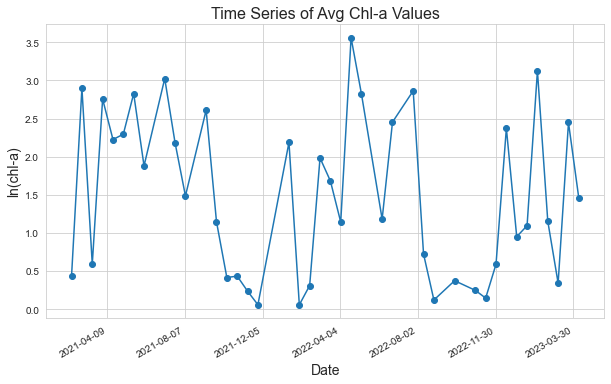

In [38]:
# Set the style of the plot
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['ln_chl_a'], marker='o', linestyle='-')

# Format the x-axis to display the dates in a more readable format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120))  # adjust the interval as needed
plt.gcf().autofmt_xdate()  # rotate the x labels

# Add a title and labels to the axes
plt.title('Time Series of Avg Chl-a Values', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('ln(chl-a)', fontsize=14)
# Show the plot
plt.show()

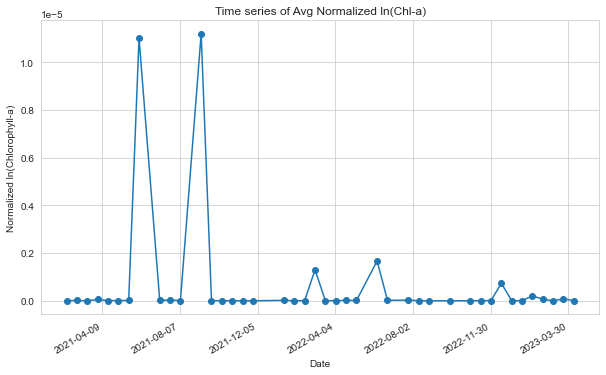

In [39]:
#Create the plot for normalized Chlorophyll-a values
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['ln_chl_a_norm'], marker='o', linestyle='-')

#Format the x-axis as datetime
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120)) # set interval to 10 days

#Set the labels and title
plt.xlabel('Date')
plt.ylabel('Normalized ln(Chlorophyll-a)')
plt.title('Time series of Avg Normalized ln(Chl-a)')

#Rotate date labels automatically
plt.gcf().autofmt_xdate()

#Show the plot
plt.show()

# DUE TO CLOUD COVER NO IMAGES FOR 6-10, 5-25, 5-09 in 2023
# OPEN LAYER SELECTION TO VIEW 
Cloud cover leads to missing datasets and sections.

In [40]:
# Set the map to focus on the study area
chloro_map.centerObject(aoi, zoom=11)
chloro_map.add_colorbar_branca(vis_params= chloro_params, colors = turbo_palette,vmin =  0, vmax = 3, label = 'mg m^-3')
chloro_map